# Introduction

Bon, les time series c'est très lourd dans notre cas. De plus il n'y a pas vraiment de périodicité détectée à part sur les semaines. On peut donc essayer de faire une approche beaucoup plus basique en encodant les années, les jours et les mois de manière beaucoup plus simples que avant.



In [1]:
#Bibliothèques
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from timeseries_utils import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_intact = pd.read_csv('x_train.csv')
y_intact = pd.read_csv('y_train.csv')
X_test_intact = pd.read_csv('x_test.csv')

#Separation du y
X_total = X_intact.copy()
X_total['y'] = y_intact['y']


In [2]:
X_total['date'] =pd.to_datetime(X_total['date'],format='%Y-%m-%d')
X_total["jour"] = X_total["date"].dt.day_name()
X_total['jour_mois'] = X_total['date'].dt.day
X_total['annee'] = X_total['date'].dt.year-2015
X_total['mois'] = X_total['date'].dt.month

X_test = X_test_intact.copy()
X_test['date'] =pd.to_datetime(X_test['date'],format='%Y-%m-%d')
X_test["jour"] = X_test["date"].dt.day_name()
X_test['jour_mois'] = X_test['date'].dt.day
X_test['annee'] = X_test['date'].dt.year-2015
X_test['mois'] = X_test['date'].dt.month

X_total.head()

X_total.head()

,date,station,job,ferie,vacances,y,jour,jour_mois,annee,mois
0,2015-01-01,1J7,1,1,1,7,Thursday,1,0,1
1,2015-01-01,O2O,1,1,1,0,Thursday,1,0,1
2,2015-01-01,8QR,1,1,1,9,Thursday,1,0,1
3,2015-01-01,UMC,1,1,1,9,Thursday,1,0,1
4,2015-01-01,FK3,1,1,1,28,Thursday,1,0,1


In [3]:
categorical_cols = ['jour,station']

ordinal_encoder = OrdinalEncoder()

label_X = X_total.copy()
label_X_test = X_test.copy()
label_X['jour'] = ordinal_encoder.fit_transform(label_X[['jour']])
label_X_test['jour'] = ordinal_encoder.transform(label_X_test[['jour']])
label_X['station'] = ordinal_encoder.fit_transform(label_X[['station']])
label_X_test['station'] = ordinal_encoder.transform(label_X_test[['station']])

y = label_X['y']
#display(label_X)




# Regression

Le preprocess est fini, plus qu'à entraîner tout ça

In [6]:
label_X = label_X.drop(['y','date'],axis=1)


### Random Forest

On va créer un premier modèle avec des random forest tout simplement, on verra XGBoost et les autres après. On va se faire un petit Grid search soyons fous

In [6]:
# gs_params = {"cv": 2, "n_jobs": -1, "verbose": 1}


# # Dataset
# # X_train,X_test,y_train,y_test = train_test_split(label_X,y,train_size = 0.8,test_size=0.2)

# # scaler = StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# # X_test = scaler.transform(X_test)


# param_grid = {
# 'n_estimators': [10, 50, 100,500,1000,10000],  # Nombre d'estimateurs
# 'max_depth': [1,5, 10, 20, 30]  # Profondeur maximale de l'arbre
# }
# grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')
# grid_search.fit(label_X, y)
# # Grid search
# # for name, clf, params in [("Random forest", RandomForestRegressor(), tree_params)]:
# #     grid = GridSearchCV(estimator=clf, param_grid=params, **gs_params)
# #     grid.fit(X_train, y_train)
# #     scores[-1].append(grid.score(X_test, y_test))

# results = pd.DataFrame(grid_search.cv_results_)

# # Sélectionner les colonnes qui vous intéressent (paramètres et scores)
# selected_columns = ['param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score']

# # Afficher les résultats sous forme de matrice
# print(results[selected_columns])


In [7]:
# for score in scores:
#     print(score)

In [8]:
from sklearn.metrics import mean_absolute_percentage_error
depth = 5
n_estimators = np.arange(1000,100000,step=10000)
score = []
for x in n_estimators:
    print(x)
    X_train,X_test,y_train,y_test = train_test_split(label_X,y,train_size = 0.8,test_size=0.2)
    model = RandomForestRegressor(n_estimators=x,max_depth=depth)
    model.fit(X_train,y_train)
    score.append(mean_absolute_percentage_error(y_test,model.predict(X_test)))
    print(mean_absolute_percentage_error(y_test,model.predict(X_test)))

plt.plot(n_estimators,score)

    


1000


KeyboardInterrupt: 

Impossible de faire converger le modèle, plusieurs pistes :
- réduire la taille du set de données : regarder la moyenne et voir si on peut pas enlever certaines années et les mois par exemple vu qu'on a pas de lien de mensualité
- faire station par station ? Trouver 1 ou 2 ou 3 modeles qui marchent bien selon la taile de la station et procéder ainsi ???????

# $2^{ème}$ approche
On va tenter de simplifier le vecteur X pour que ce soit moins long.
On sait qu'on peut drop sans trop de soucis : 
- Les valeurs avant 2019, ce qui simplifiera déjà beaucoup
- ... et c'est tout en fait !

On pourrait penser les mois, mais ça serait donc difficile de prédire l'affluence. Les autres spécificitées sont importantes

On est un peu coincé... heureusement SKlearn est à notre rescousse  : https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

Le fait de diviser en plusieurs sets est vraiment sympa, ça sera très bien pour entraîner nos modèles

In [9]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=2,
    gap = 30#valeurs à changer et à tester
)

X_time = label_X.copy()
X_time['y'] = y
X_time['date'] = X_total['date']
#X_time = X_time.drop(['jour_mois','annee','mois'],axis=1)

X_time_lim = X_time[X_time['date'].dt.year >=2020]
y = X_time_lim['y']
X_time_lim = X_time_lim.drop(['y','date'],axis = 1)
X_time_test = label_X_test.copy()
X_time_test = X_time_test.drop(['date'],axis = 1)

all_splits = list(ts_cv.split(X_time_lim, y))
train_0, test_0 = all_splits[0]
X_time_lim.iloc[test_0]



,station,job,ferie,vacances,jour,jour_mois,annee,mois
411209,58.0,1,0,0,0.0,11,7,2
411210,61.0,1,0,0,0.0,11,7,2
411211,219.0,1,0,0,0.0,11,7,2
411212,56.0,1,0,0,0.0,11,7,2
411213,184.0,1,0,0,0.0,11,7,2
...,...,...,...,...,...,...,...,...
822148,210.0,1,0,0,4.0,21,7,4
822149,109.0,1,0,0,4.0,21,7,4
822150,330.0,1,0,0,4.0,21,7,4
822151,412.0,1,0,0,4.0,21,7,4


In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

gbrt = HistGradientBoostingRegressor(random_state=42)

def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_mean_absolute_percentage_error"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_mean_absolute_percentage_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"percentage: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


evaluate(gbrt, X_time_lim, y, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 100.0
Mean Absolute Error:     2456.974 +/- 34.008
percentage: 15.722 +/- 0.647


C'est pas dégueu du tout !!! On va tester voir ce qu'on peut faire sur le X_test en prenant d'abord les paramètres par défaut. J'ai vraiment envie de voir ce que ça donne si je fais une soumission...

In [ ]:
model_2.fit(X_time_lim,y)
#X_time_test = X_time_test.drop(['index'],axis = 1)
y_pred = model_2.predict(X_time_test)


In [ ]:
y_rendu=pd.read_csv('y_rendu.csv')
y_rendu['y'] = y_pred
y_rendu.to_csv('rendu_traite.csv', index=False)

Avec cette prédiction, le score obtenu est de 1700. C'est pas fou mais je pense que l'on est sur une bonne voie ! 

In [ ]:
model_2 = HistGradientBoostingRegressor(learning_rate=0.05,max_iter=1000000,random_state=42)
ts_cv = TimeSeriesSplit(
    n_splits=12,
    gap = 30#valeurs à changer et à tester
)
evaluate(model_2, X_time_lim, y, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 381.0
Mean Absolute Error:     2276.622 +/- 254.778
percentage: 14.726 +/- 1.860


In [ ]:
model_3 = XGBRegressor(learning_rate=0.1,n_estimators = 10000,random_state=42,verbose =1)
ts_cv = TimeSeriesSplit(
    n_splits=12,
    gap = 30#valeurs à changer et à tester
)
evaluate(model_3, X_time_lim, y, cv=ts_cv, model_prop="n_iter_")

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import SGDRegressor
model_3 = SGDRegressor(verbose = 0,max_iter = 10000,random_state=42)
ts_cv = TimeSeriesSplit(
    n_splits=12,
    gap = 30#valeurs à changer et à tester
)
evaluate(model_3, X_time_lim, y, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 615.1666666666666
Mean Absolute Error:     3120663304693.522 +/- 2949437644834.397
percentage: 25974545721.153 +/- 23249671823.918


Bon... ça reste très limité. Il va falloir essayer de prendre en main la data pour avoir un truc potable sinon ça va pas le faire du tout.
- On va essayer de replot sur une et deux semaines pour voir des périodicité (de préférence hors vacances), et essayer de coder celles-ci. 
- On va essayer de faire une moyenne glissante pour voir des trends sur les stations.
- On peut aussi OOH certaines features, puisque le HistoricalGradientRegressor va super vite...
- Dernier recours, encoder les petites stations et les grosses stations séparément


In [12]:
y_sep = y_intact.copy()
y_sep[['date', 'station']] = y_sep['index'].str.split('_', expand=True)



,index,y,date
station,,,
M36,2015-01-01_M36,15190,2015-01-01
M36,2016-01-01_M36,20411,2016-01-01
M36,2017-01-01_M36,14034,2017-01-01
M36,2018-01-01_M36,20746,2018-01-01
M36,2019-01-01_M36,21611,2019-01-01
...,...,...,...
M36,2018-12-31_M36,32247,2018-12-31
M36,2019-12-31_M36,38904,2019-12-31
M36,2020-12-31_M36,14016,2020-12-31


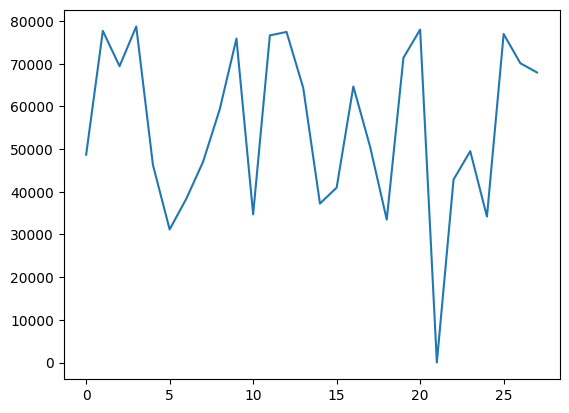

In [13]:

y_traitement = y_sep.copy()
y_traitement.set_index("station",inplace=True)

# tab_station= y_traitement.loc['1J7']
tab_station_2 = y_traitement.loc['M36']#M36
# nb_station = []
nb_station_2 = []
# for x in tab_station['y']:
#     nb_station.append(x)

for x in tab_station_2['y']:
    nb_station_2.append(x)
A = np.arange(0,len(tab_station_2['y']))
plt.plot(A[0:28],nb_station_2[1725:1725+28])
display(tab_station_2)

Il y a bien une "pseudo périodicité" de trois jours mais ça ne saute pas vraiment aux yeux. On va essayer de voir les trends
Tiré de Kaggle

<AxesSubplot: title={'center': 'Tunnel Traffic - 365-Day Moving Average'}, xlabel='date'>

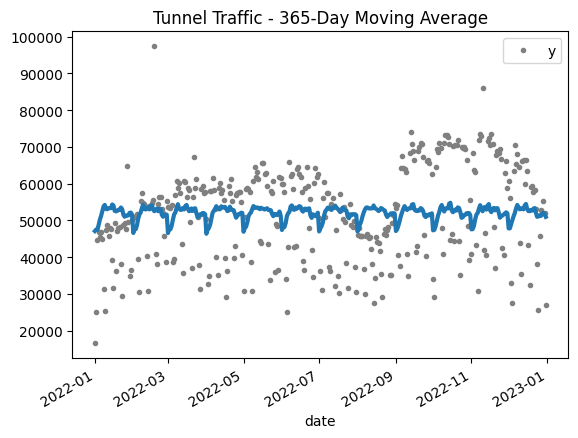

In [14]:
tab_trend = tab_station_2.copy()
tab_trend['date'] = pd.to_datetime(tab_trend['date'],format='%Y-%m-%d')
tab_trend = tab_trend[tab_trend['date'].dt.year ==2022]
# tab_trend = tab_trend[tab_trend['date'].dt.month>=3]
# tab_trend = tab_trend[tab_trend['date'].dt.month<=5]
tab_trend = tab_trend.drop(['index'],axis=1)
tab_trend = tab_trend.reset_index(drop=True)
tab_trend = tab_trend.set_index(['date'])
moving_average = tab_trend['y'].rolling(
    window=60,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=30,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tab_trend.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
)


On observe un comportement un peu sinusoïdal de fréquence 6 mois. Est-ce que ça s'encode ? Oui on peut faire un modèle hybride entre sinusoïde. Mais est-ce que ça sera vraiment utile ? Je pense pas... 
Manifestement, il y a des périodicités dans les tendances mais comment coder cela ? On va essayer de faire un OOH et voir ce que ça donne mais je ne suis pas particulièrement optimiste... On va regarder un peu ce que dit ce site :
https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html


De plus je ne suis pas sûr que ça soit utile d'avoir un modèle qui prenne en compte toutes les stations. On va essayer de voir pour 2 stations différentes comment ça se présente, avec des affluences similaires XTG et R83

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11016\2873788812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqXTG['y'] = freqXTG['y']/freqXTG['y'].max()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11016\2873788812.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqR83['y'] = freqR83['y']/freqR83['y'].max()


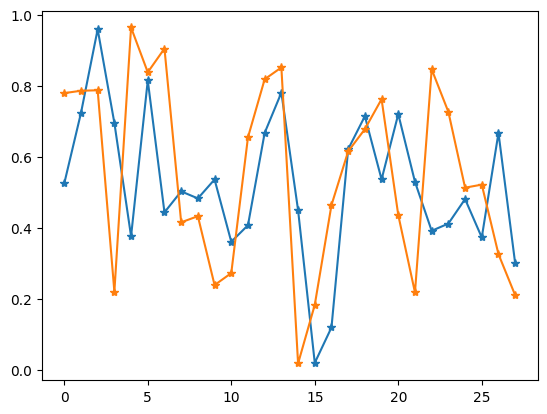

In [29]:
freqXTG = y_traitement.loc['XTG']#.drop(['index'])
freqR83 = y_traitement.loc['R83']#.drop(['index'])
#freqXTG.set_index['date']
#freqR83.set_index['date']

freqXTG['y'] = freqXTG['y']/freqXTG['y'].max()
freqXTG = freqXTG.drop(['index'],axis=1)
freqR83['y'] = freqR83['y']/freqR83['y'].max()
freqR83 = freqR83.drop(['index'],axis=1)
l_XTG,l_R83 = [],[]
for x in freqXTG['y']:
    l_XTG.append(x)
for x in freqR83['y']:
    l_R83.append(x)
A = np.arange(0,len(tab_station_2['y']))
plt.plot(A[0:28],l_R83[1900:1900+28],marker = '*')
plt.plot(A[0:28],l_XTG[1900:1900+28],marker = '*')

Ca se ressemble globalement, on peut plot la différence absolue aussi

0.22212668451721948


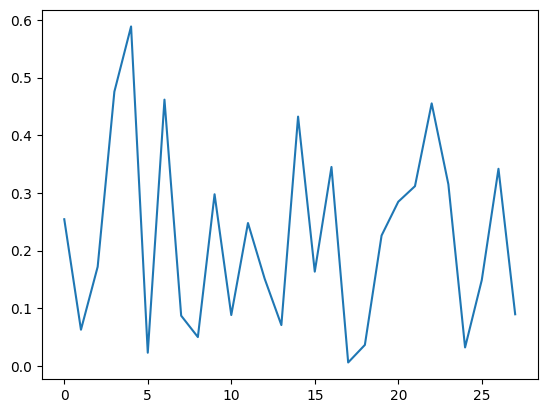

In [36]:
plt.plot(A[0:28],np.abs(np.array(l_XTG[1900:1900+28]) - np.array(l_R83[1900:1900+28])))
print(np.mean(np.abs(np.array(l_XTG[1900:1900+28])- np.array(l_R83[1900:1900+28]))))

Et à un jour de lag

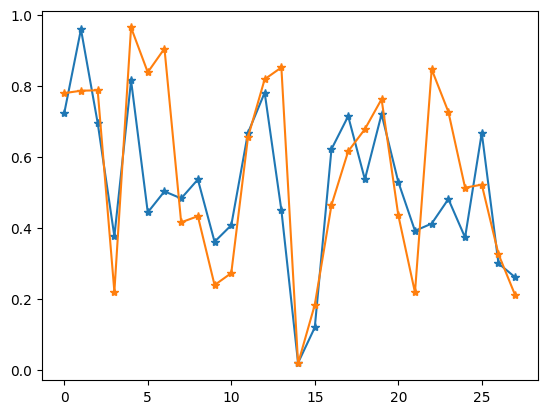

In [32]:
plt.plot(A[0:28],l_R83[1901:1901+28],marker = '*')
plt.plot(A[0:28],l_XTG[1900:1900+28],marker = '*')

Ok il y a clairement des liens on peut faire un truc à mon avis. Comme on peut observer, mettre des lags ça va êtrer super important (ci dessus un lag de 1). On va déjà essayer de train sur une seule station. La XTG.

In [15]:
one_hot_encoder = OneHotEncoder()
X_station = X_total.set_index(['station'])
X_XTG = X_station.loc['XTG']
# OH_cols = pd.DataFrame(one_hot_encoder.fit_transform(X_XTG[['jour']]))
# OH_cols.index = X_XTG.index
# X_XTG = X_XTG.drop(['jour'],axis =1)
# X_XTG = pd.concat([X_XTG,OH_cols],axis =1)
X_XTG.sort_values('date',ascending=True,inplace=True)
display(X_XTG)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12956\2331491470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_XTG.sort_values('date',ascending=True,inplace=True)


,date,job,ferie,vacances,y,jour,jour_mois,annee,mois
station,,,,,,,,,
XTG,2015-01-01,1,1,1,1535,Thursday,1,0,1
XTG,2015-01-02,1,0,1,6262,Friday,2,0,1
XTG,2015-01-03,0,0,1,5127,Saturday,3,0,1
XTG,2015-01-04,0,0,1,2992,Sunday,4,0,1
XTG,2015-01-05,1,0,0,12151,Monday,5,0,1
...,...,...,...,...,...,...,...,...,...
XTG,2022-12-27,1,0,1,9092,Tuesday,27,7,12
XTG,2022-12-28,1,0,1,9869,Wednesday,28,7,12
XTG,2022-12-29,1,0,1,9896,Thursday,29,7,12


In [18]:
X_XTG2 = X_XTG.copy()
steps = 365
X_XTG2 = X_XTG2.reset_index(drop = True)
X_XTG2 = X_XTG2.drop(['jour_mois','mois','annee','jour'],axis=1)
X_XTG_train = X_XTG2[:-steps]
y_XTG_train = pd.DataFrame(X_XTG_train['y'])
#X_XTG_train = X_XTG_train.drop(['y'],axis = 1)
X_XTG_test = X_XTG2[-steps:]
y_XTG_test = pd.DataFrame(X_XTG_test['y'])
#X_XTG_test = X_XTG_test.drop(['y'],axis = 1)


In [19]:
display(X_XTG_train)

,date,job,ferie,vacances,y
0,2015-01-01,1,1,1,1535
1,2015-01-02,1,0,1,6262
2,2015-01-03,0,0,1,5127
3,2015-01-04,0,0,1,2992
4,2015-01-05,1,0,0,12151
...,...,...,...,...,...
2550,2021-12-27,1,0,1,8433
2551,2021-12-28,1,0,1,8782
2552,2021-12-29,1,0,1,7262
2553,2021-12-30,1,0,1,7538


In [44]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(n_estimators=10000),
                 lags      = 6
             )

forecaster.fit(y = X_XTG_train['y'],exog=X_XTG_train[['job','ferie','vacances']])


In [45]:
from sklearn.metrics import mean_absolute_error
steps = 365
predictions = forecaster.predict(steps=steps,exog=X_XTG_test[['job','ferie','vacances']])
predictions.head(5)

print(mean_absolute_error(y_XTG_test,predictions))

2351.503351749786


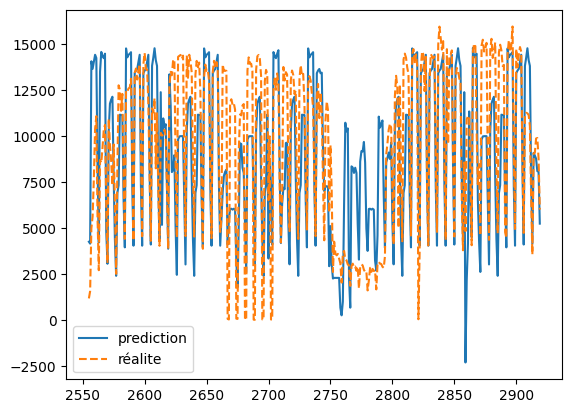

In [42]:

plt.plot(predictions,label='prediction')
plt.plot(y_XTG_test,label = 'réalite',linestyle = '--')
plt.legend()

C'est pas trop mal, assez prometteur en réalité. Il va falloir essayer d'affiner le modèle ensuite.

In [31]:
X_XTG3=X_XTG2.copy()
steps = 365
X_XTG_train = X_XTG3[:-steps]
y_XTG_train = pd.DataFrame(X_XTG_train['y'])
#X_XTG_train=X_XTG_train.drop(['y'])
#X_XTG_train = X_XTG_train.drop(['y'],axis = 1)
X_XTG_test = X_XTG2[-steps:]
y_XTG_test = pd.DataFrame(X_XTG_test['y'])
#X_XTG_test=X_XTG_test.drop(['y'])

In [32]:
model = XGBRegressor()
model.fit(X_XTG_train,y_XTG_train)
y_pred = model.predict(X_XTG_test)
print(mean_absolute_percentage_error(y_XTG_test,y_pred))

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date: datetime64[ns]